# Polygonalize your data

## What?

**Polygonalize**: Convert your data from *raster* to *vector*.

## Why?

Polygonalization is most useful when you have a raster of *categorical* data such as land-cover or ecosystem types. You can use the resulting polygons to crop and clip additional datasets, particularly ones with a different grid.

Note that polygonalization can be an intensive process for large datasets! Consider computing and applying a mask instead if your datasets have matching grids.

## How?

We'll explore two methods here:
  * [geopandas and rioxarray, from spatial-dev.guru](https://spatial-dev.guru/2022/04/16/polygonize-raster-using-rioxarray-and-geopandas/) - easy to parallelize
  * gdal_polygonize - takes care of the complexities

In [82]:
import functools
import operator
import os
import time
import warnings

from dask.diagnostics import ResourceProfiler
from dask.distributed import Client
import dask.array as da
import dask.dataframe as dd
import dask.config
import geofeather
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray as rxr

## The Data

We'll use National Land Cover Database (NLCD) 2019 CONUS data. From the description:
  > The National Land Cover Database (NLCD) provides nationwide data on land cover and land cover change at a 30m resolution with a 16-class legend based on a modified Anderson Level II classification system. NLCD 2019 represents the latest evolution of NLCD land cover products focused on providing innovative land cover and land cover change data for the Nation.

You can download the NLCD at [Multi-Resolution Land Characteristics Consortium data download site](https://www.mrlc.gov/data). 

Some key details about the NLCD data:
  - About 30 GB - 'medium-sized' data could be challenging for personal computers
  - [ERDAS IMAGINE](https://www.loc.gov/preservation/digital/formats/fdd/fdd000420.shtml)) proprietary format, with .img extension
  - Only 16 classes -> uint8 datatype (and MUCH smaller files)

In [22]:
# Import the data using rioxarray
nlcd_path = os.path.join(
    '..', 'data', 
    'nlcd_2019_land_cover_l48_20210604',
    'nlcd_2019_land_cover_l48_20210604.img')

In [23]:
nlcd_raw = rxr.open_rasterio(nlcd_path, masked=True).squeeze()
nlcd_raw

<xarray.DataArray (y: 104424, x: 161190)>
[16832104560 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 -2.493e+06 -2.493e+06 ... 2.343e+06 2.343e+06
  * y            (y) float64 3.31e+06 3.31e+06 3.31e+06 ... 1.773e+05 1.773e+05
    spatial_ref  int64 0
Attributes: (12/18)
    LAYER_TYPE:                 thematic
    OVERVIEWS_ALGORITHM:        IMAGINE Nearest Neighbor Resampling
    STATISTICS_EXCLUDEDVALUES:  
    STATISTICS_HISTOBINVALUES:  7853863229|0|0|0|0|0|0|0|0|0|0|472399232|9624...
    STATISTICS_HISTOMAX:        255
    STATISTICS_HISTOMIN:        0
    ...                         ...
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          32.689899151583
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  Layer_1

We aren't going to be able to do much with this `DataArray` because it is ~30GB (My computer has 32GB of RAM, and that's high for a personal computer). As a rule of thumb, your computer will start having trouble with datasets as you get close to the size of your computers RAM.

There are lots of ways to improve performance. We already talked about:
  * chunking
  * local clusters

In [30]:
# This is a medium/large dataset - we need chunks!
nlcd_raw = rxr.open_rasterio(
    nlcd_path, 
    masked=True,
    chunks='auto').squeeze()
nlcd_raw

<xarray.DataArray (y: 104424, x: 161190)>
dask.array<getitem, shape=(104424, 161190), dtype=float32, chunksize=(11264, 11264), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 -2.493e+06 -2.493e+06 ... 2.343e+06 2.343e+06
  * y            (y) float64 3.31e+06 3.31e+06 3.31e+06 ... 1.773e+05 1.773e+05
    spatial_ref  int64 0
Attributes: (12/18)
    LAYER_TYPE:                 thematic
    OVERVIEWS_ALGORITHM:        IMAGINE Nearest Neighbor Resampling
    STATISTICS_EXCLUDEDVALUES:  
    STATISTICS_HISTOBINVALUES:  7853863229|0|0|0|0|0|0|0|0|0|0|472399232|9624...
    STATISTICS_HISTOMAX:        255
    STATISTICS_HISTOMIN:        0
    ...                         ...
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          32.689899151583
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  Layer_1

In [25]:
# Get rid of unnecessary coordinates to speed up computations
nlcd = nlcd_raw.drop(['band', 'spatial_ref'])
nlcd

<xarray.DataArray (y: 104424, x: 161190)>
dask.array<getitem, shape=(104424, 161190), dtype=float32, chunksize=(11264, 11264), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -2.493e+06 -2.493e+06 ... 2.343e+06 2.343e+06
  * y        (y) float64 3.31e+06 3.31e+06 3.31e+06 ... 1.773e+05 1.773e+05
Attributes: (12/18)
    LAYER_TYPE:                 thematic
    OVERVIEWS_ALGORITHM:        IMAGINE Nearest Neighbor Resampling
    STATISTICS_EXCLUDEDVALUES:  
    STATISTICS_HISTOBINVALUES:  7853863229|0|0|0|0|0|0|0|0|0|0|472399232|9624...
    STATISTICS_HISTOMAX:        255
    STATISTICS_HISTOMIN:        0
    ...                         ...
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          32.689899151583
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  Layer_1

How many chunks?

* Too many -> lots of overhead from starting and stopping processes
* Too few -> memory can't handle it

We'll let xarray take care of it by using the 'auto' value, but tweaking this parameter can improve performance dramatically.

In [34]:
# Let dask split large chunks created during processing
dask.config.set({"array.slicing.split_large_chunks": True})

# Turn off the client if it is already running
try:
    client.close()
except:
    pass

# Setup a local cluster with 4 threads
client = Client(n_workers=1, threads_per_worker=4)
client.cluster

Check out the [dask Worker documentation](https://distributed.dask.org/en/latest/worker.html#memtrim): we want to consider whether to have multiple:
 * **processes**: have their own memory
and/or
 * **threads**: share memory

Communication among processes requires of overhead because items in memory must be passed around. However - Python has something called the Global Interpreter Lock (GIL) which limits access to the Python process.

Libraries like numpy (and xarray) are about to offload work to linear algebra priocesses (this might show up as a kernel task on your computer), and so the GIL is not an issue and we may as well avoid process overhead.

Other types of computations will run into a GIL logjam, and so it's best to have multiple Python processes running without threading.

### Select a land cover type
We can check out the `nlcd_2019_land_cover_l48_20210604.xml` file to learn more about the land cover classes.

Here are some of the classes, taken from the documentation:

| Name                         | Value |
| ---------------------------- | ----- |
| Perennial Ice/Snow           | 12    |
| Developed Open Space         | 21    |
| Developed, High Intensity    | 24    |
| Barren Land                  | 31    |
| Deciduous Forest             | 41    |
| Evergreen Forest             | 42    |
| Dwarf Scrub                  | 51    |
| Grassland/Herbaceous         | 71    |
| Pasture/Hay                  | 81    |
| Cultivated Crops             | 82    |
| Woody Wetlands               | 90    |

Notice that the data publishers have left space in-between the classes as a method of grouping and in case they need to add classes in future years.

We will look at the Grassland in class, but you can try a different one if you like.

You can try running this without chunks. It crashed my kernel! But with chunks xarray defers computing so it runs instantly.

In [32]:
# Select grassland and crop
nlcd_grassland = nlcd.where(nlcd==71)
nlcd_grassland

<xarray.DataArray (y: 104424, x: 161190)>
dask.array<where, shape=(104424, 161190), dtype=float32, chunksize=(11264, 11264), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -2.493e+06 -2.493e+06 ... 2.343e+06 2.343e+06
  * y        (y) float64 3.31e+06 3.31e+06 3.31e+06 ... 1.773e+05 1.773e+05
Attributes: (12/18)
    LAYER_TYPE:                 thematic
    OVERVIEWS_ALGORITHM:        IMAGINE Nearest Neighbor Resampling
    STATISTICS_EXCLUDEDVALUES:  
    STATISTICS_HISTOBINVALUES:  7853863229|0|0|0|0|0|0|0|0|0|0|472399232|9624...
    STATISTICS_HISTOMAX:        255
    STATISTICS_HISTOMIN:        0
    ...                         ...
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          32.689899151583
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  Layer_1

We need to get rid of data ASAP! 

When we use drop=True, it gets rid of a little data, but also forces xarray to compute. This is worth it if you can crop off a large portion of the dataset this way.

In [35]:
# Select only the perennial ice/snowpixels
nlcd_ice = nlcd.where(nlcd==12, drop=True)
nlcd_ice

<xarray.DataArray (y: 29388, x: 22193)>
dask.array<where, shape=(29388, 22193), dtype=float32, chunksize=(1510, 317), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -2.242e+06 -2.23e+06 ... -8.022e+05 -8.021e+05
  * y        (y) float64 3.143e+06 3.143e+06 3.143e+06 ... 1.586e+06 1.586e+06
Attributes: (12/18)
    LAYER_TYPE:                 thematic
    OVERVIEWS_ALGORITHM:        IMAGINE Nearest Neighbor Resampling
    STATISTICS_EXCLUDEDVALUES:  
    STATISTICS_HISTOBINVALUES:  7853863229|0|0|0|0|0|0|0|0|0|0|472399232|9624...
    STATISTICS_HISTOMAX:        255
    STATISTICS_HISTOMIN:        0
    ...                         ...
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          32.689899151583
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  Layer_1

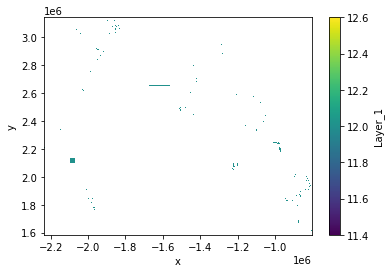

In [47]:
# Plot a low-res version
nlcd_ice_thumb = nlcd_ice.coarsen(x=4, y=4, boundary='trim').mean()
nlcd_ice_thumb.plot()

## Method 1: `rioxarray` and `geopandas`

Adapted from [spatial-dev.guru](https://spatial-dev.guru/2022/04/16/polygonize-raster-using-rioxarray-and-geopandas/)

The basic workflow is:
  1. Calculate the centroids of each pixel in the class
  2. Buffer the centroids to the pixel extent
  3. Merge the buffer polygons

### Testing with a toy dataset

This is a lot of data. We need to test the workflow on a smaller chunk that will run.

In particular, we should keep an eye on the edge effects - is the method able to agglomerate contiguous pixels without resulting in fuzzy edges?

In [48]:
nlcd_crop = nlcd_grassland[10000:10500,10000:13000]

# Calculate the buffer distance from pixel size
buffer_distance = abs(nlcd_grassland.rio.resolution()[0]) / 2

nlcd_crop_df = (
    nlcd_crop
    .to_dataframe('grassland')
    .dropna()
    .reset_index()
    .drop('grassland', axis=1))
nlcd_crop_gds = (
    gpd.GeoSeries(
        gpd.points_from_xy(nlcd_crop_df.x, nlcd_crop_df.y),
        crs = nlcd_grassland.rio.crs)
    # Buffer pixel-sized squares around the points
    .buffer(
        distance=buffer_distance,
        cap_style=3))

<AxesSubplot:>

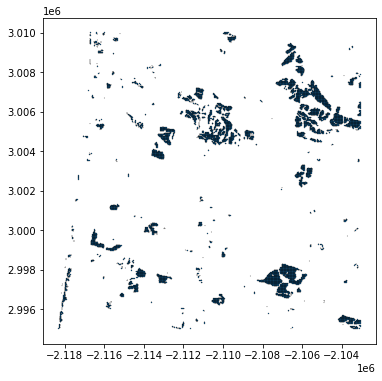

In [49]:
nlcd_crop_gds.plot(edgecolor='black', linewidth=0.2, figsize=(6, 6))

<AxesSubplot:>

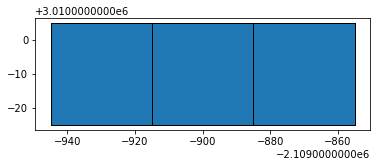

In [50]:
# Check that the buffers look correct
nlcd_pix = nlcd_crop_gds[3:6]
nlcd_pix.plot(edgecolor='black')

<AxesSubplot:>

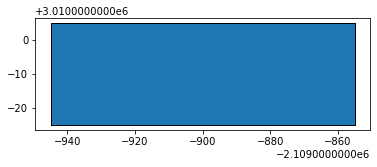

In [51]:
# Merge contiguous pixels. How did we do?
gpd.GeoSeries([nlcd_pix.unary_union]).plot(edgecolor='black')

<AxesSubplot:>

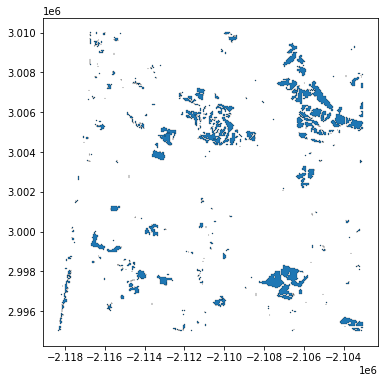

In [52]:
#Display the whole dataset - now we can see blue
nlcd_crop_union = gpd.GeoSeries([nlcd_crop_gds.unary_union])
nlcd_crop_union.plot(edgecolor='black', linewidth=.2, figsize=(6, 10))

### Scaling up

The procedure above works great for our toy dataset. To scale it up, we start by encapsulating the workflow in a `pixels_to_polygon` function.

In [15]:
# This crashes the python kernel
# nlcd_df = (nlcd_grassland.to_dataframe(name='grassland'))

In [55]:
@dask.delayed
def pixels_to_polygon(arr, buffer_distance):
    """
    Convert DataArray to a MultiPolygon
    
    Extract coordinates, buffer them to encompass the entire
    pixel, and merge contiguous pixels
    
    Parameters
    ==========
      arr : xr.DataArray
        The masked array to convert to a polygon
        
      buffer_distance : numeric
        How far to buffer; should be .5 * resolution to 
        avoid artifacts
        
    Returns
    =======
      pd.DataFrame
        A DataFrame with one row containing the resulting
        MultiPolygon. This is for compatibility with dask.
    """
    # Convert array to dataframe, dropping extras
    df = (
        arr
        .to_dataframe('exists')
        # Get rid of null locations
        .dropna()
        .reset_index()
        # Now that NA values are gone this column is redundant
        .drop('exists', axis=1))
    
    # Buffer and unite pixels
    polygon = (
        gpd.GeoSeries(
            gpd.points_from_xy(df.x, df.y))
        # Buffer pixel-sized squares around the points
        .buffer(
            distance=buffer_distance,
            cap_style=3)
        # Drop internal points
        .unary_union)
    
    # Return as DataFrame to use dask concatenation
    return pd.DataFrame({'geometry': [polygon]})

We'd like to use dask to avoid having to do things like load-balancing. However, the existing mapping functions in dask can produce an array from an array or a dataframe from a dataframe, but not a dataframe from and array. We'll write a new one, `map_arr_to_df`:

In [54]:
def map_arr_to_df(dask_arr, map_function, meta, toy=False, *args, **kwargs):
    """
    A function to map dask blocks and return a dataframe
    
    Similar to dask.array.map_blocks, but returning a
    dataframe instead of another array. Allows for
    using high performance tools to convert arrays to 
    dataframes (see https://github.com/dask/dask/issues/7589)
    
    Parameters
    ==========
      dask_arr : array-like
        dask-enabled array, e.g. xr.DataArray with chunks
        specified
      map_function : function
        The function to apply to dask_arr. Must return
        pd.DataFrame
      meta : dict
        The datatypes of the resulting DataFrame, 
        by column name
      toy : int or bool
        The number of chunks if limiting
      args : list
        function arguments
      kwargs : dict
        function keyword arguments
        
    Returns
    =======
      df : pd.DataFrame
        Concatenated dask.DataFrame of results, not computed
    """
    # Get all the chunks as DataArrays
    slices = dask.array.core.slices_from_chunks(
        dask.array.asarray(dask_arr).chunks)
    if toy:
        slices = slices[:toy]
    
    block_iter = map(
        functools.partial(operator.getitem, dask_arr),
        slices)

    # Run pixels_to_polygon on all the chunks
    dfs = [
        dd.from_delayed(
            map_function(b, *args, **kwargs), 
            # Tell dask the data format of the dataframe columns
            meta=meta) 
        for b in block_iter]

    df = dd.concat(dfs)
    
    return df.dropna()

OK! Let's try it on our toy dataset first to make sure its working. We'll set the chunk size pretty small at 250 so we can see what is happening:

In [61]:
nlcd_crop_df = map_arr_to_df(
    nlcd_crop.chunk({'x': 250, 'y': 250}), 
    map_function=pixels_to_polygon, 
    buffer_distance=buffer_distance, 
    meta=dd.utils.make_meta([('geometry', 'object')])).compute()

In [62]:
nlcd_crop_df.reset_index(drop=True, inplace=True)
nlcd_crop_df

,geometry
0,"(POLYGON ((-2114775 3002745, -2114775 3002715,..."
1,"(POLYGON ((-2105985 3002565, -2105985 3002535,..."
2,"(POLYGON ((-2118345 2995035, -2118315 2995035,..."
3,"(POLYGON ((-2112255 2995035, -2112255 2995065,..."
4,"(POLYGON ((-2107695 2995815, -2107695 2995785,..."


<AxesSubplot:>

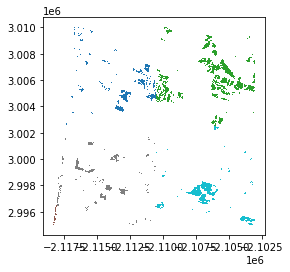

In [63]:
gpd.GeoSeries(nlcd_crop_df.geometry).plot(cmap='tab10')

<AxesSubplot:>

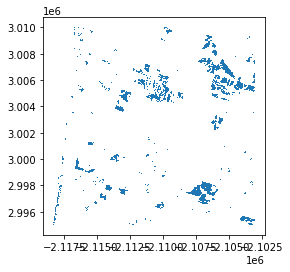

In [64]:
nlcd_crop_gs = gpd.GeoSeries(gpd.GeoSeries(nlcd_crop_df.geometry).unary_union)
nlcd_crop_gs.plot(cmap='tab10')

In [21]:
# This causes a memory leak warning on my system
# nlcd_grassland_df = map_dask_blocks(
#     nlcd_grassland, 
#     map_function=pixels_to_polygon, 
#     buffer_distance=buffer_distance, 
#     meta=dd.utils.make_meta([('geometry', 'object')])).compute()

Ok, we have a problem! Fortunately you can run some tests to figure out the best parameters for your system.

It seems like there are a couple of variables that matter here:
  * chunk size (larger chunks -> more memory use)
  * number of threads
  * processes vs. threads
  
Let's experiment and find  out what the best settings are! We'll use the `toy` option in the map_dask_blocks function to just run 4 blocks.

Chunk sizes need to be multiples of the file's native chunk size - otherwise data will be loaded multiple times. We'll infer based on the automatic chunk sizes from xarray the best chunk sizes

In [80]:
chunk_size = nlcd_grassland.chunks[0][0]

# Try to match multiples of the native chunk size
chunk_sizes = [(chunk_size // 64)*(2**power) for power in range(1,7)]
chunk_sizes

[352, 704, 1408, 2816, 5632, 11264]

In [85]:
client.close()
time.sleep(2)
client = Client()

with warnings.catch_warnings():
    warnings.simplefilter('error')
    
with ResourceProfiler() as profiler:
    for chunk_size in chunk_sizes:
        print('Chunk size: {} pixels'.format(chunk_size))
        nlcd_grassland_df = map_arr_to_df(
            nlcd_grassland.chunk({'x': chunk_size, 'y': chunk_size}), 
            map_function=pixels_to_polygon, 
            buffer_distance=buffer_distance, 
            toy=4,
            meta=dd.utils.make_meta([('geometry', 'object')])).compute()
    profiler.visualize()

Chunk size: 352 pixels
Chunk size: 704 pixels
Chunk size: 1408 pixels
Chunk size: 2816 pixels
Chunk size: 5632 pixels


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.76 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.76 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.76 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

Chunk size: 11264 pixels


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.80 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.80 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.80 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

KilledWorker: ('pixels_to_polygon-20433ef4-cddd-4cc6-a26c-8dc3ac0fb431', <WorkerState 'tcp://10.0.1.11:62793', name: 3, memory: 0, processing: 4>)

Looks like 5632 is too large a chunk size on my

In [37]:
with ResourceProfiler(dt=0.1) as profiler:
    for n_workers in range(1, 5):
        for threads_per_worker in range(1, 5):
            print('{} workers, {} threads per worker'.format(
                n_workers, threads_per_worker))
            
            # Shut down the existing client
            client.close()
            time.sleep(2)
            
            # Start the client
            client = Client(
                n_workers=n_workers, threads_per_worker=threads_per_worker)

            # Run  profiled job
            nlcd_grassland_df = map_dask_blocks(
                nlcd_grassland.chunk({'x': 5000, 'y': 5000}), 
                map_function=pixels_to_polygon, 
                buffer_distance=buffer_distance, 
                toy=4,
                meta=dd.utils.make_meta([('geometry', 'object')])).compute()
            
profiler.visualize()

1 workers, 1 threads per worker
1 workers, 2 threads per worker
1 workers, 3 threads per worker
1 workers, 4 threads per worker
2 workers, 1 threads per worker
2 workers, 2 threads per worker
2 workers, 3 threads per worker
2 workers, 4 threads per worker
3 workers, 1 threads per worker


Task was destroyed but it is pending!
task: <Task pending name='Task-191234' coro=<Cluster._sync_cluster_info() done, defined at /Users/elsa/opt/miniconda3/envs/ea-nbg/lib/python3.8/site-packages/distributed/deploy/cluster.py:98> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fd9d52ebc10>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/elsa/opt/miniconda3/envs/ea-nbg/lib/python3.8/site-packages/tornado/ioloop.py:688]>


3 workers, 2 threads per worker
3 workers, 3 threads per worker
3 workers, 4 threads per worker
4 workers, 1 threads per worker


Task was destroyed but it is pending!
task: <Task pending name='Task-192560' coro=<Cluster._sync_cluster_info() done, defined at /Users/elsa/opt/miniconda3/envs/ea-nbg/lib/python3.8/site-packages/distributed/deploy/cluster.py:98> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fd9bac73880>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/elsa/opt/miniconda3/envs/ea-nbg/lib/python3.8/site-packages/tornado/ioloop.py:688]>


4 workers, 2 threads per worker
4 workers, 3 threads per worker
4 workers, 4 threads per worker


Figure(id='60610', ...)

In [ ]:
# shape_path = os.path.join('..', 'data', 'grassland.shp')
# gpd.GeoSeries(nlcd_crop_df.geometry).to_file(shape_path)

In [ ]:
nlcd_ice_df = map_arr_to_df(
    nlcd_ice.chunk({'x': 2816, 'y': 2816}), 
    map_function=pixels_to_polygon, 
    buffer_distance=buffer_distance, 
    meta=dd.utils.make_meta([('geometry', 'object')])).compute()

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.78 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Worker is at 85% memory usage. Pausing worker.  Process memory: 6.84 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.84 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.84 GiB -- Worker memory limit: 8.00 GiB
distr

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.82 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.82 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.82 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.82 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.82 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.82 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.81 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.76 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.76 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.76 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.74 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.74 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.74 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.74 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.74 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.74 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.61 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.59 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.58 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.57 GiB -- Worker memory limit: 8.00 GiB
distr

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 6.56 GiB -- Worker memory limit: 8.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

In [ ]:
ice_feather_path = os.path.join('..', 'data', 'ice.feather')
to_geofeather(nlcd_grassland_df, feather_path)

In [ ]:
nlcd_df.reset_index(inplace=True)
nlcd_gdf = gpd.GeoDataFrame(
    nlcd_df, 
    geometry=gpd.points_from_xy(df.x, df.y))

In [ ]:
# Don't forget to close the dask Client!
client.close()